<a href="https://colab.research.google.com/github/Aphilak660510747/229352-stat/blob/main/Lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [12]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [13]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [14]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [15]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [16]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [17]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [18]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

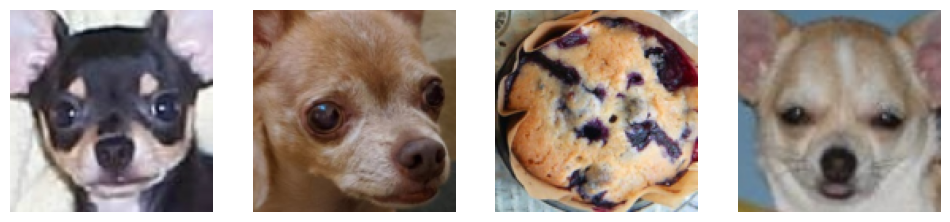

tensor([0, 0, 1, 0])


In [19]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [21]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 128 * 3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [26]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [27]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [28]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [29]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [30]:
train_batches = iter(train_loader)
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [32]:
y_hat = model(X)


y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [33]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())


#### Calculate the gradient (Backward pass)

In [34]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()


In [35]:
model.parameters()

<generator object Module.parameters at 0x788f1addec00>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [36]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad


# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [37]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [38]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.7821731567382812]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

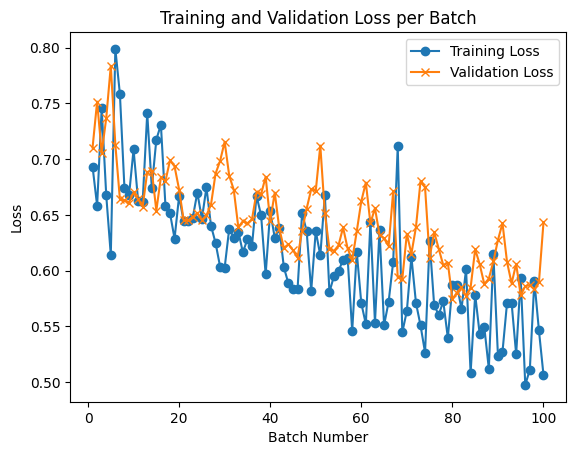

In [39]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [41]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy



NameError: name 'accuracy' is not defined

--- Training with Learning Rate: 0.01 ---
Epoch 1/10, Loss: 0.7627
Epoch 2/10, Loss: 0.5738
Epoch 3/10, Loss: 0.4221
Epoch 4/10, Loss: 0.2345
Epoch 5/10, Loss: 0.1095
Epoch 6/10, Loss: 0.1291
Epoch 7/10, Loss: 0.1373
Epoch 8/10, Loss: 0.1451
Epoch 9/10, Loss: 0.3486
Epoch 10/10, Loss: 0.1454
------------------------------
--- Training with Learning Rate: 0.001 ---
Epoch 1/10, Loss: 0.6975
Epoch 2/10, Loss: 0.1448
Epoch 3/10, Loss: 0.0019
Epoch 4/10, Loss: 0.0003
Epoch 5/10, Loss: 0.0002
Epoch 6/10, Loss: 0.0002
Epoch 7/10, Loss: 0.0001
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0001
Epoch 10/10, Loss: 0.0001
------------------------------
--- Training with Learning Rate: 0.0001 ---
Epoch 1/10, Loss: 0.6927
Epoch 2/10, Loss: 0.5024
Epoch 3/10, Loss: 0.2183
Epoch 4/10, Loss: 0.0601
Epoch 5/10, Loss: 0.0194
Epoch 6/10, Loss: 0.0092
Epoch 7/10, Loss: 0.0056
Epoch 8/10, Loss: 0.0038
Epoch 9/10, Loss: 0.0028
Epoch 10/10, Loss: 0.0021
------------------------------
--- Training with Learnin

Accuracy on the test set: 48.00%
--- Displaying 4 incorrectly classified images ---


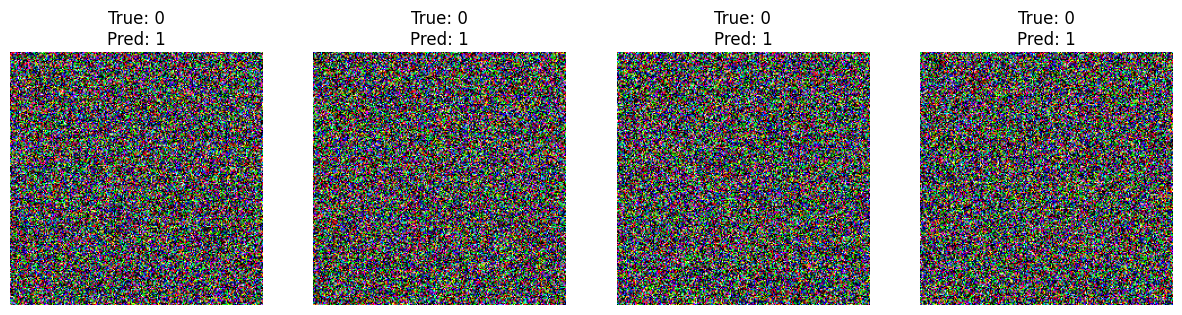

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, transform=None):
        self.num_samples = num_samples
        self.transform = transform
        self.images = torch.randn(num_samples, 3, 224, 224)
        self.labels = torch.randint(0, 2, (num_samples,), dtype=torch.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = DummyDataset(num_samples=1000)
test_dataset = DummyDataset(num_samples=200)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 1.) สร้างโครงข่ายประสาทเทียมตามภาพ

input_size = 3 * 224 * 224
hidden_layer1_size = 128
hidden_layer2_size = 64
hidden_layer3_size = 32
output_size = 1 # For binary classification with Sigmoid

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, hidden_layer1_size),
    nn.ReLU(),
    nn.Linear(hidden_layer1_size, hidden_layer2_size),
    nn.ReLU(),
    nn.Linear(hidden_layer2_size, hidden_layer3_size),
    nn.ReLU(),
    nn.Linear(hidden_layer3_size, output_size),
    nn.Sigmoid() # Sigmoid to output a probability between 0 and 1
)

# Loss function and optimizer
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for Sigmoid output
# If using a final Linear layer without Sigmoid, use nn.BCEWithLogitsLoss() instead
epochs = 10

# 2.) ฝึกโมเดลด้วย learning rate ที่กำหนด
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

for lr in learning_rates:
    print(f"--- Training with Learning Rate: {lr} ---")
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Reset model weights for each learning rate
    def reset_weights(m):
        if isinstance(m, nn.Linear):
            m.reset_parameters()
    model.apply(reset_weights)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    print("-" * 30)



# 3.) คำนวณความแม่นยำบน Test Set
print("--- Calculating Test Accuracy ---")
correct = 0
total = 0
incorrect_predictions = []

with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y_hat = (y_hat > 0.5).float()

        total += y.size(0)
        correct += (y_hat == y).sum().item()

        # 4.) หาภาพที่ทำนายผิดพลาด
        misclassified_indices = (y_hat != y).nonzero(as_tuple=True)[0]
        for idx in misclassified_indices:
            if len(incorrect_predictions) < 4:
                incorrect_predictions.append((X[idx], y[idx], y_hat[idx]))

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

# 4.) แสดงภาพที่ทำนายผิดพลาด
print("--- Displaying 4 incorrectly classified images ---")
if len(incorrect_predictions) > 0:
    fig, axes = plt.subplots(1, len(incorrect_predictions), figsize=(15, 5))
    if len(incorrect_predictions) == 1:
        axes = [axes] # Ensure axes is an array for consistent indexing

    for i, (image_tensor, true_label, pred_label) in enumerate(incorrect_predictions):
        ax = axes[i]
        # Reshape tensor for display: (C, H, W) -> (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
        ax.set_title(f"True: {int(true_label)}\nPred: {int(pred_label)}")
        ax.axis('off')
    plt.show()
else:
    print("No incorrectly classified images found in the first few batches.")